In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pylab
import math
%matplotlib inline
from scipy import misc

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    # find those ending point sets of segments belong to the left and right lane line respectively
    leftSlopePoints=[]
    rightSlopePoints=[]
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)           
            if (slope>-1 and slope<-0.6):                
                leftSlopePoints.append([x1,y1])
                leftSlopePoints.append([x2,y2])
            elif (slope<1 and slope>0.4):                
                rightSlopePoints.append([x1,y1])
                rightSlopePoints.append([x2,y2])
    rightSlopePointArray = np.asarray(rightSlopePoints)
    x = rightSlopePointArray[:,0]
    y = rightSlopePointArray[:,1]
    pright = np.polyfit(x,y,1)
    # pright[0] * x + pright[1] = y
    xright_min = min(x)
    yright_min = xright_min*pright[0]+pright[1]    

    leftSlopePointArray= np.asarray(leftSlopePoints)
    x = leftSlopePointArray[:,0]
    y = leftSlopePointArray[:,1]
    pleft = np.polyfit(x,y,1)
    # pleft[0] * x + pleft[1] = y
    xleft_max = max(x);
    yleft_max = xleft_max*pleft[0] + pleft[1]
    
    # make two lines have same top points (keep the lower one)
    if yright_min < yleft_max:
        ymiddle = yleft_max
        xright_min = (ymiddle-pright[1])/pright[0]
    elif yright_min > yleft_max:
        ymiddle = yright_min
        xleft_max = (ymiddle-pleft[1])/pleft[0]    
    
    cv2.line(img, (0,int(pleft[1])), (int(xleft_max), int(ymiddle)), color, thickness)
    height, width, channels = img.shape
    cv2.line(img, (int(xright_min),int(ymiddle)), (int(width), int(width*pright[0]+pright[1])),color, thickness)
    
    return None

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, λ)
def shrinkimage(img,factor=0.5):
    """
    To apply an size modifying to the original image "img", with a default factor of 0.5
    """
    return cv2.resize(img,dsize=(0,0),fx=factor,fy=factor)

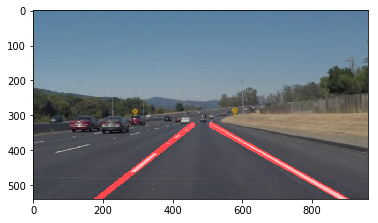

In [44]:
filename = 'solidWhiteCurve'
image = mpimg.imread('test_images/' + filename + '.jpg')

image.shape
ylen = image.shape[0]
xlen = image.shape[1]
zlen = image.shape[2]
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

GaussianKernel = 5
blurred = gaussian_blur(gray, GaussianKernel) 
misc.imsave('report/' + filename + '_blur.jpg', shrinkimage(blurred))
low_th = 100  # 50
hi_th = 200  # 150
edges = canny(blurred, low_th, hi_th)
misc.imsave('report/' + filename + '_edge.jpg', shrinkimage(edges))
# Next we'll create a masked edges image using cv2.fillPoly()
vertices = np.array([[(0, ylen), (xlen * 0.47, ylen * 0.58), (xlen * 0.53, ylen * 0.58), (xlen, ylen)]],
                    dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
misc.imsave('report/' + filename + '_masked_edges.jpg', shrinkimage(masked_edges))
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2
theta = np.pi / 180
threshold = 40  # 30 #1
min_line_length = 5  # 20
max_line_gap = 2  # 1
# Run Hough on edge detected image
lineimage = hough_lines(masked_edges, rho, theta, threshold,
                        min_line_length, max_line_gap)
plt.imshow(lineimage)
misc.imsave('report/' + filename + '_lineimage.jpg', shrinkimage(lineimage))
final_image = weighted_img( lineimage, image)
plt.imshow(final_image)
misc.imsave('report/' + filename + '_finalimage.jpg', shrinkimage(final_image))

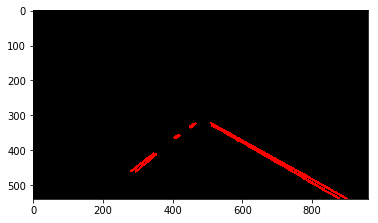

In [42]:
rho = 2 #2
theta = np.pi / 180
threshold = 30  # 30 #1
min_line_length =  5  # 20
max_line_gap = 2  # 1
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), color=[255, 0, 0], thickness=5)
plt.imshow(line_img)
#misc.imsave('report/' + filename + '_hough.jpg', shrinkimage(line_img))